#### Discretisation plus Encoding

What shall we do with the variable after discretisation? should we use the buckets as a numerical variable? or should we use the intervals as categorical variable?

The answer is, you can do either.

If you are building decision tree based algorithms and the output of the discretisation are integers (each integer referring to a bin), then you can use those directly, as decision trees will pick up non-linear relationships between the discretised variable and the target.

If you are building linear models instead, the bins may not necessarily hold a linear relationship with the target. In this case, it may help improve model performance to treat the bins as categories and to one hot encoding, or target guided encodings like mean encoding, weight of evidence, or target guided ordinal encoding.

We can easily do so by combining feature-engine's discretisers and encoders.


Dataset: Titanic

In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

In [55]:
# load the the Titanic Dataset

data = pd.read_csv('../datasets/titanic.csv',
                   usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [56]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3, random_state=0)

In [57]:
# The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.
def impute_na(data, variable):

    df = data.copy()

    # random sampling
    df[variable + '_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample

    return df[variable + '_random']

In [58]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

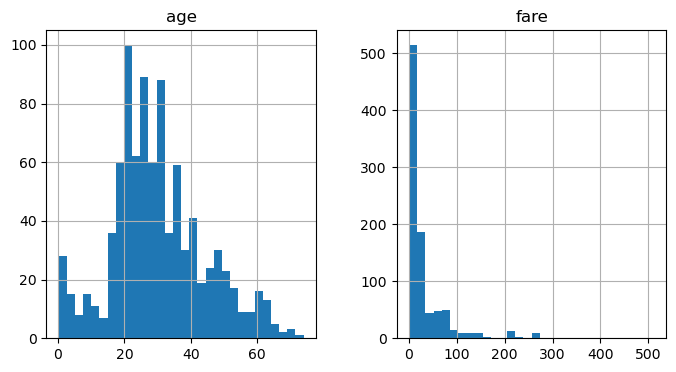

In [59]:
# let's explore the distribution of age

X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

**Equal Frequency Discretization**

In [60]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [61]:
disc.bin_edges_

array([array([ 0.1667 ,  7.55003, 14.93336, 22.31669, 29.70002, 37.08335,
              44.46668, 51.85001, 59.23334, 66.61667, 74.     ])         ,
       array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
              307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ])          ],
      dtype=object)

In [62]:
train_t = disc.transform(X_train[['age', 'fare']])

train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])

train_t.index = X_train.index
train_t


,age,fare
501,1.0,0.0
588,0.0,0.0
402,4.0,0.0
1193,5.0,0.0
686,2.0,0.0
...,...,...
763,0.0,0.0
835,3.0,0.0
1216,9.0,0.0
559,2.0,0.0


In [63]:
test_t = disc.transform(X_test[['age','fare']])
test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])
test_t.index = X_test.index
test_t

,age,fare
1139,5.0,0.0
533,2.0,0.0
459,5.0,0.0
1150,0.0,0.0
393,3.0,0.0
...,...,...
914,4.0,0.0
580,4.0,0.0
1080,2.0,0.0
1249,4.0,0.0


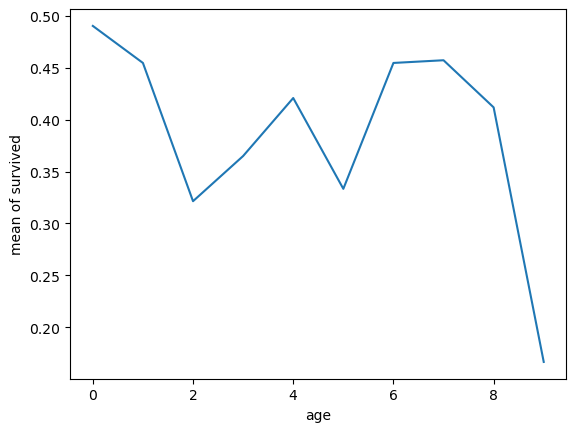

In [64]:
pd.concat([train_t, y_train], axis=1).groupby('age')['survived'].mean().plot()
plt.ylabel("mean of survived")
plt.show()

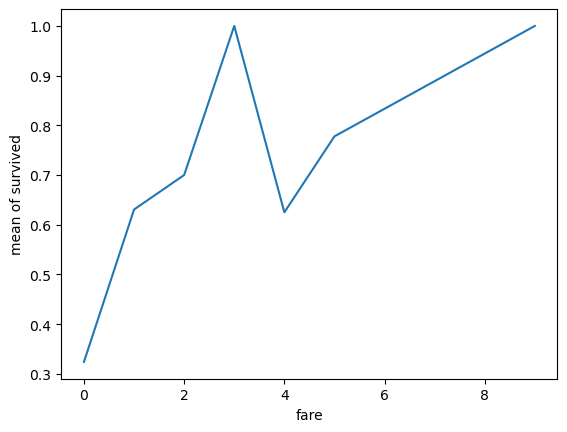

In [65]:
pd.concat([train_t, y_train], axis=1).groupby('fare')['survived'].mean().plot()
plt.ylabel("mean of survived")
plt.show()

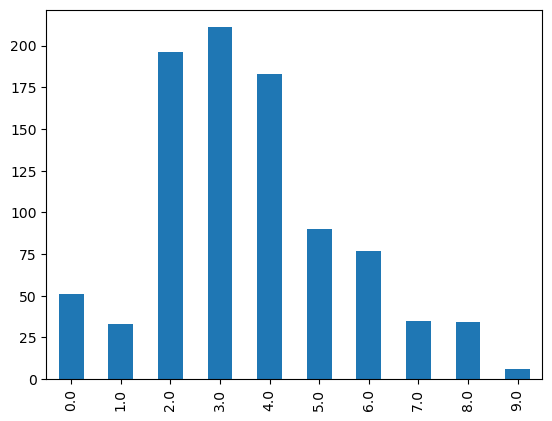

In [66]:
train_t.age.value_counts().plot.bar()
plt.show()

In [67]:
train_t.age.value_counts().sort_values().index

Float64Index([9.0, 1.0, 8.0, 7.0, 0.0, 6.0, 5.0, 4.0, 2.0, 3.0], dtype='float64')

In [68]:
# we can turn the previous commands into 2 functions

def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = df.groupby([variable])[target].mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [78]:
train_set = pd.concat([train_t, y_train], axis=1)
test_set = pd.concat([test_t, y_test], axis=1)
for var in train_t.columns:
    mapping = find_category_mappings(train_set, var, 'survived')
    integer_encode(train_set, test_t, var, mapping)


In [79]:
train_set.head()

,age,fare,survived
501,6,0,1
588,9,0,1
402,5,0,1
1193,2,0,0
686,1,0,1


In [81]:
test_set.head()

,age,fare,survived
1139,5.0,0.0,0
533,2.0,0.0,1
459,5.0,0.0,0
1150,0.0,0.0,0
393,3.0,0.0,0


<Figure size 700x500 with 0 Axes>

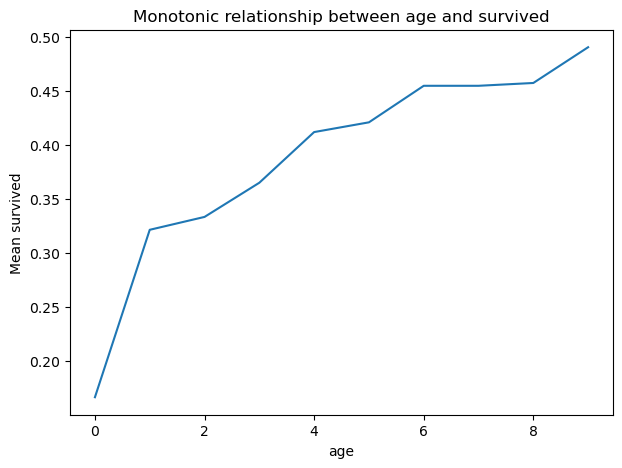

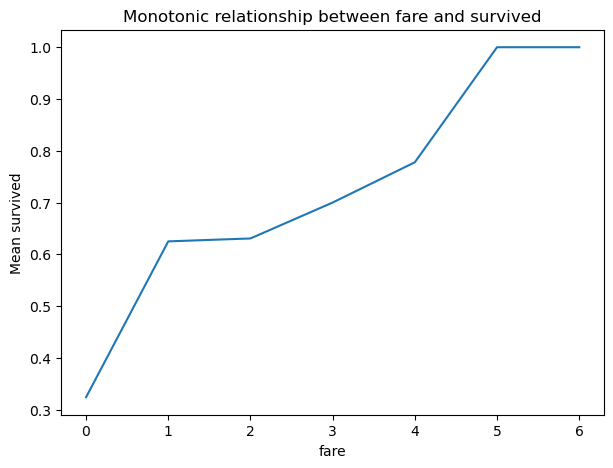

In [83]:
for var in train_set.columns:
    if not var == "survived":
        fig = plt.figure(figsize=(7,5))
        fig = train_set.groupby([var])['survived'].mean().plot()
        fig.set_title('Monotonic relationship between {} and survived'.format(var))
        fig.set_ylabel('Mean survived')
        plt.show()

Now we obtained a monotonic relationship between variables and target.